# Análise de Sentimento Financeiro - BERT

Este notebook é a continuação do notebook com modelos clássicos, aqui, iremos treinar um modelo BERT para análise de sentimento em dados financeiros, juntamente de uma sobre-amostração da classe minoritária para lidar com o desbalanceamento de classes.

In [14]:
#Importando bibliotecas
import time

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import seaborn

import warnings
warnings.filterwarnings('ignore')

In [1]:
# Configuração do dispositivo CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

/home/apo-pc/anaconda3/envs/DataScience_Mandacaru/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando dispositivo: cuda


### Funções Auxiliares

In [ ]:
def carregar_dados():
    """Carrega os dados de diferentes caminhos possíveis"""
    caminhos = ['../data/data.csv', './data/data.csv', 'data.csv']

    for caminho in caminhos:
        try:
            df = pd.read_csv(caminho)
            print(f"✓ Dados carregados com sucesso de: {caminho}")
            return df
        except FileNotFoundError:
            continue

    raise FileNotFoundError("Arquivo de dados não encontrado em nenhum caminho.")

def aumentar_dados_minoritarios(X, y):
    """Aplica aumento de dados balanceando as classes"""
    from collections import Counter
    import random

    # Contar classes
    contador = Counter(y)
    classe_majoritaria = max(contador, key=contador.get)
    max_amostras = contador[classe_majoritaria]

    X_aumentado = list(X)
    y_aumentado = list(y)

    for classe, count in contador.items():
        if count < max_amostras:
            # Selecionar amostras da classe minoritária
            indices_classe = [i for i, label in enumerate(y) if label == classe]
            amostras_classe = [X[i] for i in indices_classe]

            # Duplicar amostras aleatoriamente até equilibrar
            amostras_necessarias = max_amostras - count
            for _ in range(amostras_necessarias):
                amostra_original = random.choice(amostras_classe)
                X_aumentado.append(amostra_original)
                y_aumentado.append(classe)

    return np.array(X_aumentado), np.array(y_aumentado)

def calcular_acuracia(dataloader, model, device):
    """Calcula a acurácia do modelo"""
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    return total_correct / total_samples

# Função para calcular acurácia para o conjunto de treino
def calcular_acuracia_treino(dataloader, model, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    return total_correct / total_samples


def treinar_epoca(model, dataloader, optimizer, criterion, device):
    """Treina o modelo por uma época"""
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f"Loss: {loss.item():.4f}", end='\r')

    return total_loss / len(dataloader)

### Carregando os Dados

In [12]:

# Carregar dados
df = carregar_dados()

✓ Dados carregados com sucesso de: ../data/data.csv

Shape dos dados: (5842, 2)
Colunas: ['Sentence', 'Sentiment']

Distribuição de sentimentos:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Valores nulos por coluna:
Sentence     0
Sentiment    0
dtype: int64

Shape após limpeza: (5842, 2)


## Pré-processamento

In [3]:
# Codificação dos rótulos
encoder = LabelEncoder()
labels = encoder.fit_transform(df['Sentiment'])
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(f"\nMapeamento de rótulos: {label_mapping}")

# Divisão inicial dos dados
X_train_val, X_test_final, y_train_val, y_test_final = train_test_split(
    df['Sentence'].values,
    labels,
    test_size=0.2,
    stratify=df['Sentiment'].values,
    random_state=19
)

print(f"\nDivisão dos dados:")
print(f"Treino+Validação: {len(X_train_val)} amostras")
print(f"Teste final: {len(X_test_final)} amostras")


Mapeamento de rótulos: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}

Divisão dos dados:
Treino+Validação: 4673 amostras
Teste final: 1169 amostras


### Sobre-amostragem das classe minoritária

In [4]:
# Aplicar aumento de dados
X_train_augmented, y_train_augmented = aumentar_dados_minoritarios(X_train_val, y_train_val)

print(f"\nDados após aumento:")
print(f"Antes: {len(X_train_val)} amostras")
print(f"Depois: {len(X_train_augmented)} amostras")
print(f"Distribuição após aumento: {np.bincount(y_train_augmented)}")


Dados após aumento:
Antes: 4673 amostras
Depois: 7512 amostras
Distribuição após aumento: [2504 2504 2504]


Função para Tokenização e criação do Dataset

In [5]:
class SentimentDataset(Dataset):
    """Dataset personalizado para análise de sentimentos"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Inicializar tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("Tokenizer BERT carregado.")

✓ Tokenizer BERT carregado


## Modelagem: Classificação de Sentimentos Com BERT

In [6]:
class SentimentBERT(nn.Module):
    """Modelo BERT para classificação de sentimentos"""

    def __init__(self, n_classes=3, dropout=0.3):
        super(SentimentBERT, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return self.classifier(output)

## Treinamento e Avaliação do Modelo

In [8]:
# Dividir dados de treino em treino/validação
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_augmented, y_train_augmented, test_size=0.2,
    stratify=y_train_augmented, random_state=42
)

# Criar datasets finais
train_dataset_final = SentimentDataset(X_train_final, y_train_final, tokenizer)
val_dataset_final = SentimentDataset(X_val_final, y_val_final, tokenizer)
test_dataset_final = SentimentDataset(X_test_final, y_test_final, tokenizer)

# Criar dataloaders finais
train_loader_final = DataLoader(train_dataset_final, batch_size=32, shuffle=True)
val_loader_final = DataLoader(val_dataset_final, batch_size=32, shuffle=False)
test_loader_final = DataLoader(test_dataset_final, batch_size=32, shuffle=False)

# Modelo final
modelo_final = SentimentBERT(n_classes=3).to(device)
optimizer_final = torch.optim.AdamW(modelo_final.parameters(), lr=2e-5)
criterion_final = nn.CrossEntropyLoss()

# Treinamento final
n_epochs_final = 5
melhor_modelo = None
melhor_acc_val = 0

# Variáveis para armazenar métricas
historico_train_loss = []
historico_val_loss = []
historico_train_acc = []
historico_val_acc = []


# Treinamento final com armazenamento dos valores
print("Treinando modelo final")
for epoch in range(n_epochs_final):
    train_loss = treinar_epoca(modelo_final, train_loader_final, optimizer_final, criterion_final, device)
    val_loss = 0
    val_steps = 0

    # Calcular loss de validação
    modelo_final.eval()
    with torch.no_grad():
        for batch in val_loader_final:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = modelo_final(input_ids, attention_mask)
            loss = criterion_final(outputs, labels)

            val_loss += loss.item()
            val_steps += 1

    val_loss /= val_steps
    train_acc = calcular_acuracia_treino(train_loader_final, modelo_final, device)
    val_acc = calcular_acuracia(val_loader_final, modelo_final, device)

    historico_train_loss.append(train_loss)  # Armazenar loss de treino
    historico_val_loss.append(val_loss)      # Armazenar loss de validação
    historico_train_acc.append(train_acc)    # Armazenar acurácia de treino
    historico_val_acc.append(val_acc)        # Armazenar acurácia de validação

    if val_acc > melhor_acc_val:
        melhor_acc_val = val_acc
        melhor_modelo = modelo_final.state_dict().copy()

    print(f"Época {epoch + 1}/{n_epochs_final}: Train_Loss={train_loss:.4f}, Val_Loss={val_loss:.4f}, "
          f"Train_Acc={train_acc:.4f}, Val_Acc={val_acc:.4f}")


# Carregar melhor modelo
modelo_final.load_state_dict(melhor_modelo)

# Carregar melhor modelo
modelo_final.load_state_dict(melhor_modelo)


=== TREINAMENTO DO MODELO FINAL ===
Treinando modelo final
Época 1/5: Train_Loss=0.6611, Val_Loss=0.4174, Train_Acc=0.8724, Val_Acc=0.8397
Época 2/5: Train_Loss=0.3189, Val_Loss=0.3597, Train_Acc=0.9248, Val_Acc=0.8703
Época 3/5: Train_Loss=0.2148, Val_Loss=0.3636, Train_Acc=0.9329, Val_Acc=0.8762
Época 4/5: Train_Loss=0.1735, Val_Loss=0.3851, Train_Acc=0.9434, Val_Acc=0.8842
Época 5/5: Train_Loss=0.1612, Val_Loss=0.3955, Train_Acc=0.9451, Val_Acc=0.8822


<All keys matched successfully>

### Plot Perda Vs Acurácia | Treino e Validação

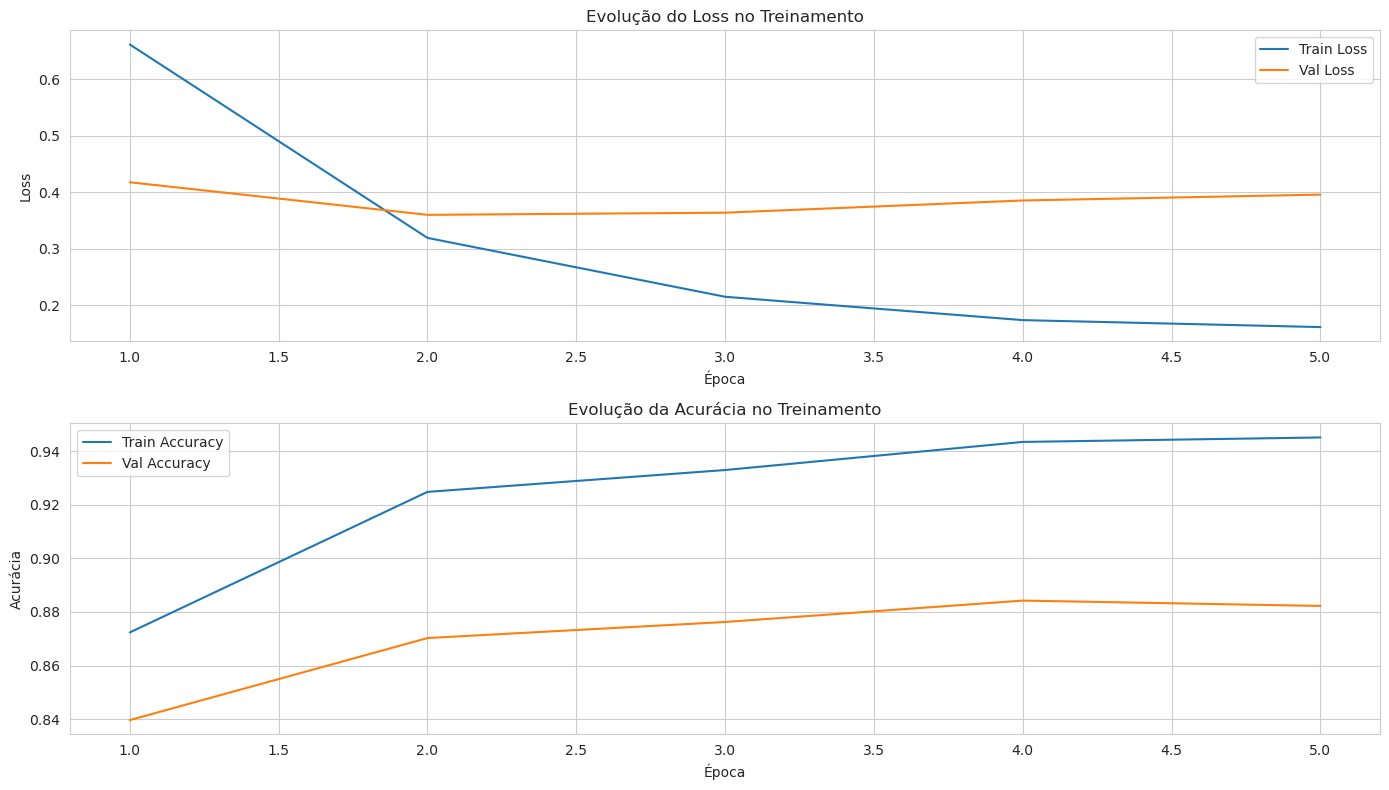

In [9]:
# Plotar Loss e Acurácia para treino e validação
plt.figure(figsize=(14, 8))

# Gráfico de Loss
plt.subplot(2, 1, 1)
plt.plot(range(1, n_epochs_final + 1), historico_train_loss, label='Train Loss')
plt.plot(range(1, n_epochs_final + 1), historico_val_loss, label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução do Loss no Treinamento')
plt.legend()

# Gráfico de Acurácia
plt.subplot(2, 1, 2)
plt.plot(range(1, n_epochs_final + 1), historico_train_acc, label='Train Accuracy')
plt.plot(range(1, n_epochs_final + 1), historico_val_acc, label='Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Evolução da Acurácia no Treinamento')
plt.legend()

plt.tight_layout()
plt.show()

Nota-se pelo grafico que o modelo apresenta uma tendência de overfitting, onde a acurácia de validação começa a divergir da acurácia de treino. A combinação de poucos dados e a complexidade do modelo BERT pode ter contribuído para isso. No entanto, a acurácia de validação ainda é aceitável, indicando que o modelo está aprendendo bem os padrões dos dados.

### Avaliação do Modelo Final

Acurácia no conjunto de teste: 0.7776

Relatório de Classificação:
              precision    recall  f1-score   support

    negative       0.48      0.80      0.60       172
     neutral       0.91      0.71      0.80       626
    positive       0.83      0.88      0.86       371

    accuracy                           0.78      1169
   macro avg       0.74      0.80      0.75      1169
weighted avg       0.82      0.78      0.79      1169



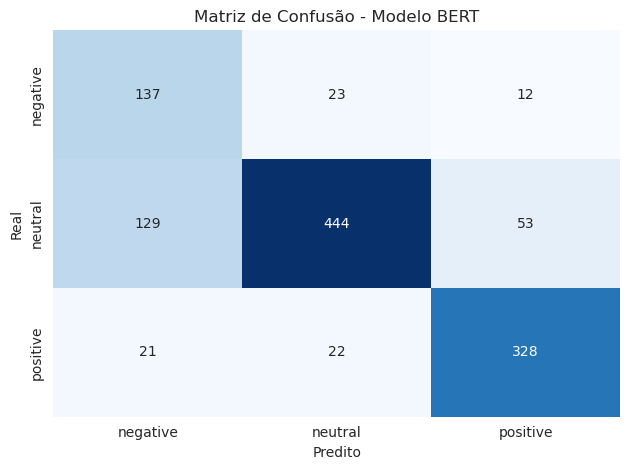

In [15]:
# Acurácia no conjunto de teste
test_acc = calcular_acuracia(test_loader_final, modelo_final, device)
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")

# Previsões detalhadas para relatório
modelo_final.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader_final:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = modelo_final(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Relatório de classificação
from sklearn.metrics import classification_report
class_names = encoder.classes_
print("\nRelatório de Classificação:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))

# Plotar a matriz de confusão com Seaborn
seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão - Modelo BERT')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


Notamos enfim que o modelo BERT treinado alcançou uma acurácia e F1-Score consideravelmente melhores do que os modelos clássicos, especialmente em relação à classe minoritária. A matriz de confusão mostra que o modelo é capaz de distinguir bem entre as classes, com poucas confusões.

O modelo é capaz de lidar de forma satisfatória com as classes de interesse, especialmente para a classe positiva.

## Medição de Latência

Finalmente, iremos medir a latência do modelo treinado para inferência. Assim, poderemos avaliar a performance do modelo em termos de tempo de resposta, e entender como ele se comporta em produção.

In [22]:


def medir_latencia_modelo(model, tokenizer, textos_teste, device, n_repeticoes=100):
    """
    Mede a latência do modelo para inferência

    Args:
        model: Modelo treinado
        tokenizer: Tokenizer BERT
        textos_teste: Lista de textos para teste
        device: Dispositivo (CPU/GPU)
        n_repeticoes: Número de repetições para média

    Returns:
        dict: Estatísticas de latência
    """
    model.eval()
    tempos = []

    # Preparar dados de teste
    encoding = tokenizer.encode_plus(
        textos_teste[0],  # Usar primeiro texto como exemplo
        max_length=128,
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Warm-up (ignorar primeiras inferências)
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_ids, attention_mask)

    # Medir latência
    with torch.no_grad():
        for _ in range(n_repeticoes):
            start_time = time.perf_counter()
            _ = model(input_ids, attention_mask)
            end_time = time.perf_counter()
            tempos.append((end_time - start_time) * 1000)  # Converter para ms

    # Calcular estatísticas
    estatisticas = {
        'latencia_media_ms': np.mean(tempos),
        'latencia_mediana_ms': np.median(tempos),
        'latencia_min_ms': np.min(tempos),
        'latencia_max_ms': np.max(tempos),
        'desvio_padrao_ms': np.std(tempos),
        'throughput_samples_per_sec': 1000 / np.mean(tempos)
    }

    return estatisticas, tempos

# Preparar textos de teste do dataset
textos_exemplo = X_test_final[:10]  # Usar os primeiros 10 textos do conjunto de teste

# 1. Latência para inferência única
print("Medindo latência:")
stats_single, tempos_single = medir_latencia_modelo(
    modelo_final, tokenizer, textos_exemplo, device, n_repeticoes=100
)
print(f"Média: {stats_single['latencia_media_ms']:.2f} ms | Mediana: {stats_single['latencia_mediana_ms']:.2f} ms | mín/máx: {stats_single['latencia_min_ms']:.2f}/{stats_single['latencia_max_ms']:.2f} ms | std.: {stats_single['desvio_padrao_ms']:.2f} ms")

Medindo latência:
Média: 5.67 ms | Mediana: 5.18 ms | mín/máx: 5.06/9.21 ms | std.: 0.96 ms


Mesmo executando em uma GPU de entrada (RTX 4060), o modelo apresenta uma baixissima latência, o que o torna adequado para aplicações em tempo real.